In [ ]:
!nvidia-smi

Sun Nov 29 01:25:02 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0    32W /  70W |   2379MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/DeepLearning20201

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1zAYAVH93pv8035fL1Si7wl1J85cSZ94I/DeepLearning20201


In [ ]:
classNames = {0: 'Speed limit (20km/h)',
 1: 'Speed limit (30km/h)',
 2: 'Speed limit (50km/h)',
 3: 'Speed limit (60km/h)',
 4: 'Speed limit (70km/h)',
 5: 'Speed limit (80km/h)',
 6: 'End of speed limit (80km/h)',
 7: 'Speed limit (100km/h)',
 8: 'Speed limit (120km/h)',
 9: 'No passing',
 10: 'No passing for vehicles over 3.5 metric tons',
 11: 'Right-of-way at the next intersection',
 12: 'Priority road',
 13: 'Yield',
 14: 'Stop',
 15: 'No vehicles',
 16: 'Vehicles over 3.5 metric tons prohibited',
 17: 'No entry',
 18: 'General caution',
 19: 'Dangerous curve to the left',
 20: 'Dangerous curve to the right',
 21: 'Double curve',
 22: 'Bumpy road',
 23: 'Slippery road',
 24: 'Road narrows on the right',
 25: 'Road work',
 26: 'Traffic signals',
 27: 'Pedestrians',
 28: 'Children crossing',
 29: 'Bicycles crossing',
 30: 'Beware of ice/snow',
 31: 'Wild animals crossing',
 32: 'End of all speed and passing limits',
 33: 'Turn right ahead',
 34: 'Turn left ahead',
 35: 'Ahead only',
 36: 'Go straight or right',
 37: 'Go straight or left',
 38: 'Keep right',
 39: 'Keep left',
 40: 'Roundabout mandatory',
 41: 'End of no passing',
 42: 'End of no passing by vehicles over 3.5 metric tons'}

In [ ]:
import pickle
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchsummary import summary
from torch.utils.data import DataLoader, TensorDataset
import csv
import torchvision

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
data = "./dataset/"
train_link = data + "train.p"
valid_link = data + "valid.p"
test_link = data + "test.p"

with open(train_link, mode = "rb") as f:
  train = pickle.load(f)
with open(valid_link, mode = "rb") as f:
  valid = pickle.load(f)
with open(test_link, mode = "rb") as f:
  test = pickle.load(f)

trainX = train["features"]
trainY = train["labels"]
testX = test["features"]
testY = test["labels"]
validX = valid["features"]
validY = valid["labels"]

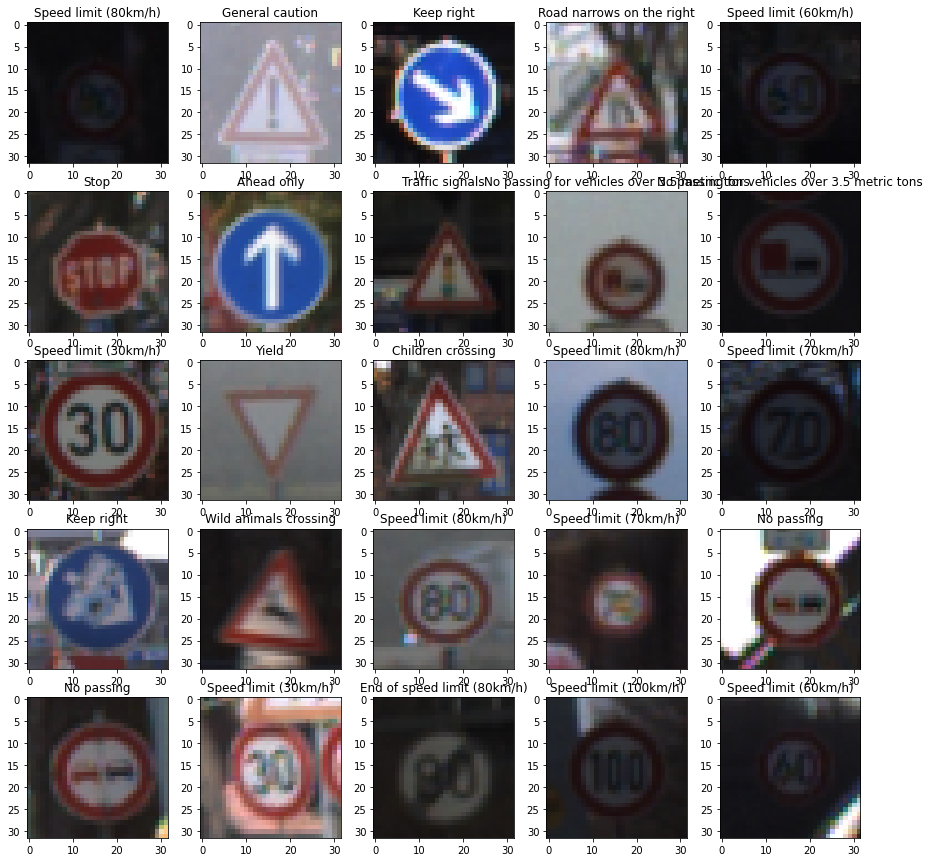

In [ ]:
fig, ax = plt.subplots(5, 5, figsize = (15, 15))
for i in range(0,25):
    sample = np.random.choice(range(len(trainX)))
    ax[i//5, i%5].imshow(trainX[sample])
    ax[i//5, i%5].set_title(classNames[trainY[sample]])    

plt.show()

In [ ]:
trainX = trainX.astype("float")/255.0
validX = validX.astype("float")/255.0
testX = testX.astype("float")/255.0

In [ ]:
trainX = torch.tensor(trainX).float().cuda()
trainY = torch.tensor(trainY).long().cuda()
testX = torch.tensor(testX).float().cuda()
testY = torch.tensor(testY).long().cuda()
validX = torch.tensor(validX).float().cuda()
validY = torch.tensor(validY).long().cuda()

In [ ]:
print('train size:', trainX.shape[0])
print('test size:', testX.shape[0])
print('valid size:', validX.shape[0])
print('input shape:', trainX[0].shape)

train size: 34799
test size: 12630
valid size: 4410
input shape: torch.Size([32, 32, 3])


In [ ]:
NUM_CLASSES = 43
input_size = (32,32,3)

class Model(nn.Module):
  def __init__(self, num_chanels=16, num_hidden=256):
    super(Model, self).__init__()
    self.num_chanels = num_chanels
    self.num_hidden = num_hidden
    self.conv = nn.ModuleList()

    self.conv.append(nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=num_chanels, kernel_size=(3,3), stride=1, padding=1),
        nn.BatchNorm2d(num_features=num_chanels),
        nn.ReLU()
    ))
    self.conv.append(nn.Sequential(
        nn.Conv2d(in_channels=num_chanels, out_channels=num_chanels, kernel_size=(3,3), stride=1, padding=1),
        nn.MaxPool2d(kernel_size=(2,2), stride=2),
        nn.BatchNorm2d(num_features=num_chanels),
        nn.ReLU()
    ))
    self.conv.append(nn.Sequential(
        nn.Conv2d(in_channels=num_chanels, out_channels=num_chanels*2, kernel_size=(3,3), stride=1, padding=1),
        nn.BatchNorm2d(num_features=num_chanels*2),
        nn.ReLU()
    ))
    self.conv.append(nn.Sequential(
        nn.Conv2d(in_channels=num_chanels*2, out_channels=num_chanels*2, kernel_size=(3,3), stride=1, padding=1),
        nn.MaxPool2d(kernel_size=(2,2), stride=2),
        nn.BatchNorm2d(num_features=num_chanels*2),
        nn.ReLU()
    ))

    self.dense = nn.Sequential(
        nn.Linear(in_features=num_chanels*2*8*8, out_features=num_hidden),
        nn.Dropout(p=0.5),
        nn.BatchNorm1d(num_features=num_hidden),
        nn.ReLU(),
        nn.Linear(in_features=num_hidden, out_features=NUM_CLASSES),
        nn.Softmax(dim=1)
    )

  def forward(self, inp):
    output = inp.permute(0, 3, 1, 2).float()
    for layer in self.conv:
      output = layer(output)
    output = torch.flatten(output, start_dim=1)
    output = self.dense(output)
    return output


In [ ]:
import time
 
def train(model, path, num_epochs=100, lr=0.01, batch_size=128, eval_every=1):
 
  with open('%s.csv' % path, mode='w', encoding='utf-8', newline='') as file:
    writer = csv.writer(file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['loss', 'train acc', 'valid acc'])
    
  train_dataset = TensorDataset(trainX, trainY)
  train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)
 
  valid_dataset = TensorDataset(validX, validY)
  valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle = False)
 
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
  criterion = nn.CrossEntropyLoss()
  best_loss = 99999
  lr_patience = 5
  lr_factor = 3
  for epoch in range(1, num_epochs+1):
    model.train()
    clock0 = time.time()
    for X, Y in train_dataloader:
      optimizer.zero_grad()
      output = model(X.cuda())
      loss = criterion(output, Y.cuda())
      # Back prop
      loss.backward()
      # Gradient descent step
      optimizer.step()
 
    clock1 = time.time()
 
    if epoch % eval_every == 0:
      train_acc, train_loss = eval(model, train_dataloader)
      valid_acc, valid_loss = eval(model, valid_dataloader)
      clock2 = time.time()
      print('| Epoch {:3d}, time={:5.1f}ms/{:5.1f}ms | Train: loss={:.3f}, acc={:5.2f}% |'.format(
          epoch, 1000 * (clock1 - clock0), 1000 * (clock2 - clock1), train_loss, 100 * train_acc), end='')
            
      print(' Valid: loss={:.3f}, acc={:5.2f}% |'.format(valid_loss, 100 * valid_acc), end='')
 
      if best_loss > valid_loss:
        best_loss = valid_loss
        torch.save(model.state_dict(),'%s.pt' % path)
        lr_patience = 5
        print(' *', end='')
      else:
        lr_patience -= 1
        if lr_patience < 0:
          lr /= lr_factor
          optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
          print(' lr={:.1e}'.format(lr), end='')
          lr_patience = 5
 
      print()
 
      with open('%s.csv' % path, mode='a', encoding='utf-8', newline='') as file:
        writer = csv.writer(file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        writer.writerow([train_loss.item(), train_acc.item(), valid_loss.item(), valid_acc.item()])
 
 
def eval(model, dataloader):
  model.eval()
  predict_true = 0
  total = 0
  loss = 0
  criterion = nn.CrossEntropyLoss()
  for X, Y in dataloader:
    with torch.no_grad():
      output = model(X.cuda())
 
    loss += criterion(output, Y.cuda())
    predicted = torch.argmax(output, dim = 1)
    predict_true += sum((predicted == Y).float())
    total += Y.shape[0]
  return predict_true/total, loss/len(dataloader)

In [ ]:
lr = 0.1
batch_size = 32
num_chanels = 48
num_hidden = 256
input_size = (32,32,3)

path = 'result/quan_model_lr_{}_sbatch_{}_nchanels_{}_nhidden_{}'.format(lr, batch_size, num_chanels, num_hidden)

model = Model(num_chanels=num_chanels, num_hidden=num_hidden).to(device)
summary(model, input_size, batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [32, 48, 32, 32]           1,344
       BatchNorm2d-2           [32, 48, 32, 32]              96
              ReLU-3           [32, 48, 32, 32]               0
            Conv2d-4           [32, 48, 32, 32]          20,784
         MaxPool2d-5           [32, 48, 16, 16]               0
       BatchNorm2d-6           [32, 48, 16, 16]              96
              ReLU-7           [32, 48, 16, 16]               0
            Conv2d-8           [32, 96, 16, 16]          41,568
       BatchNorm2d-9           [32, 96, 16, 16]             192
             ReLU-10           [32, 96, 16, 16]               0
           Conv2d-11           [32, 96, 16, 16]          83,040
        MaxPool2d-12             [32, 96, 8, 8]               0
      BatchNorm2d-13             [32, 96, 8, 8]             192
             ReLU-14             [32, 9

In [ ]:
print(path)

result/quan_model_lr_0.1_sbatch_32_nchanels_48_nhidden_256


In [ ]:
model = Model(num_chanels=num_chanels, num_hidden=num_hidden).to(device)

train(model, lr=lr, batch_size=batch_size, eval_every=1, num_epochs=100, path=path)

| Epoch   1, time=16233.2ms/2599.9ms | Train: loss=3.171, acc=63.13% | Valid: loss=3.216, acc=58.57% | *
| Epoch   2, time=16373.1ms/2640.3ms | Train: loss=3.095, acc=70.40% | Valid: loss=3.143, acc=65.62% | *
| Epoch   3, time=16572.0ms/2641.4ms | Train: loss=3.013, acc=78.64% | Valid: loss=3.056, acc=74.40% | *
| Epoch   4, time=16428.8ms/2611.1ms | Train: loss=2.977, acc=82.19% | Valid: loss=3.022, acc=77.87% | *
| Epoch   5, time=16309.2ms/2638.3ms | Train: loss=2.965, acc=83.37% | Valid: loss=3.010, acc=79.21% | *
| Epoch   6, time=16316.2ms/2606.9ms | Train: loss=2.943, acc=85.54% | Valid: loss=2.984, acc=81.84% | *
| Epoch   7, time=16383.6ms/2615.7ms | Train: loss=2.907, acc=89.26% | Valid: loss=2.934, acc=86.78% | *
| Epoch   8, time=16431.2ms/2617.0ms | Train: loss=2.870, acc=93.16% | Valid: loss=2.902, acc=90.14% | *
| Epoch   9, time=16381.9ms/2603.6ms | Train: loss=2.862, acc=93.83% | Valid: loss=2.890, acc=91.36% | *
| Epoch  10, time=16367.1ms/2601.6ms | Train: loss=2.84

In [ ]:
test_dataset = TensorDataset(testX, testY)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle = False)
model = Model(num_chanels=num_chanels, num_hidden=num_hidden).to(device)
model.load_state_dict(torch.load('%s.pt' % path))

test_acc, test_loss = eval(model, test_dataloader)
print('test acc: {:5.2f}%'.format(test_acc.item()*100))
print('test loss:', test_loss.item())

test acc: 99.16%
test loss: 2.814544677734375


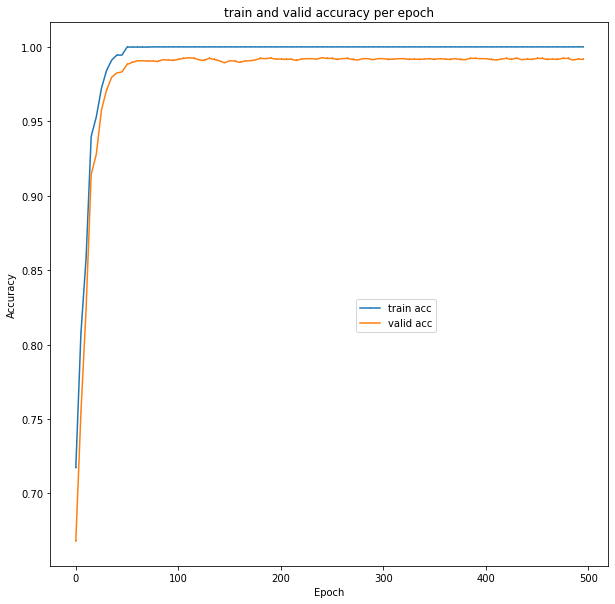

In [ ]:
with open('%s.csv' % path, mode='r', encoding='utf-8', newline='') as file:
  reader = csv.reader(file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
  states = [row for row in reader][1:]
  train_acc = [round(float(row[1]), 4) for row in states]
  valid_acc = [round(float(row[3]), 4) for row in states]

plt.figure(figsize=(10, 10))
epochs = [i*5 for i in range(len(valid_acc))]
plt.plot(epochs, train_acc, marker=',', label='train acc')
plt.plot(epochs, valid_acc, marker=',', label='valid acc')

plt.legend(bbox_to_anchor=(0.7, 0.5), loc='best')
plt.title('train and valid accuracy per epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

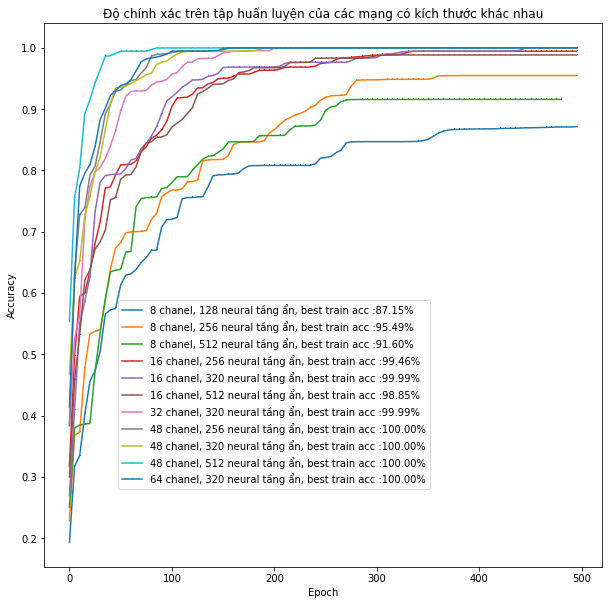

In [ ]:
sbatch=128
lr=0.01
nchanels=[8, 16, 32, 48, 64]
nhidden=[128, 256, 320, 512]

plt.figure(figsize=(10, 10))

for nc in nchanels:
  for nh in nhidden:
    try:
      path = 'result/quan_model_lr_{}_sbatch_{}_nchanels_{}_nhidden_{}'.format(lr, sbatch, nc, nh)
      with open('%s.csv'%path, 'r') as f:
        reader = csv.reader(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        states = [row for row in reader][1:]
        train_acc = [round(float(row[1]), 4) for row in states]
        epochs = [i*5 for i in range(len(train_acc))]
        plt.plot(epochs, train_acc, marker=',', label='{} chanel, {} neural tầng ẩn, best train acc :{:5.2f}%'.format(nc, nh, max(train_acc)*100))
    except:
      continue

plt.legend(bbox_to_anchor=(0.7, 0.5), loc='best')
plt.title('Độ chính xác trên tập huấn luyện của các mạng có kích thước khác nhau')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

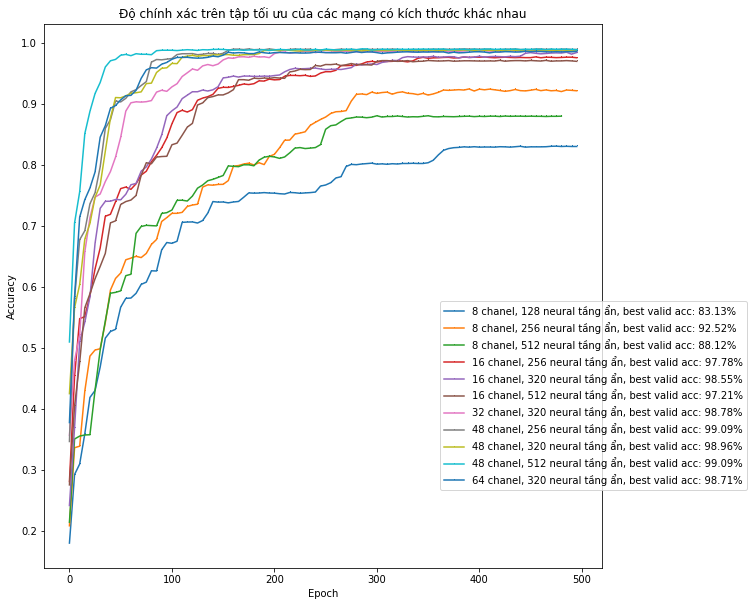

In [ ]:
sbatch=128
lr=0.01
nchanels=[8, 16, 32, 48, 64]
nhidden=[128, 256, 320, 512]

plt.figure(figsize=(10, 10))

for nc in nchanels:
  for nh in nhidden:
    try:
      path1 = 'result/quan_model_lr_{}_sbatch_{}_nchanels_{}_nhidden_{}'.format(lr, sbatch, nc, nh)
      with open('%s.csv'%path1, 'r') as f:
        reader = csv.reader(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        states = [row for row in reader][1:]
        valid_acc = []
        for row in states:
          try:
            valid_acc.append(round(float(row[3]), 4))
          except:
            valid_acc.append(round(float(row[2]), 4))
        
        epochs = [i*5 for i in range(len(valid_acc))]
        plt.plot(epochs, valid_acc, marker=',', label='{} chanel, {} neural tầng ẩn, best valid acc: {:5.2f}%'.format(nc, nh, max(valid_acc)*100))
    except:
      continue

plt.legend(bbox_to_anchor=(0.7, 0.5))
plt.title('Độ chính xác trên tập tối ưu của các mạng có kích thước khác nhau')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

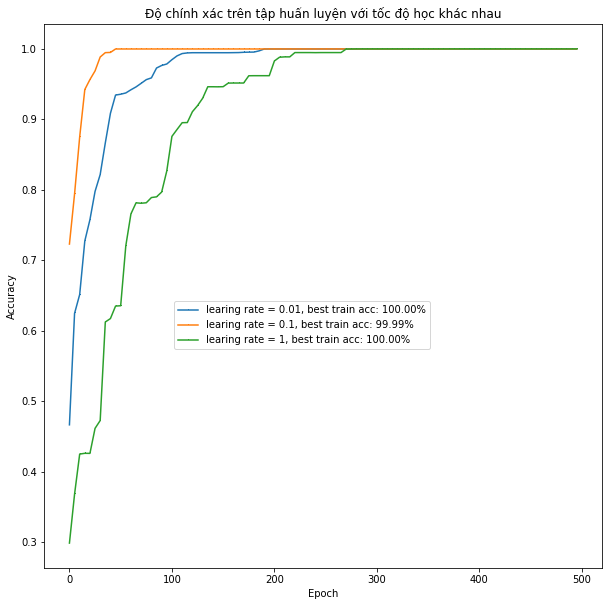

In [ ]:
sbatch=128
lrs=[0.01, 0.1, 1]
nchanels=48
nhidden=320

plt.figure(figsize=(10, 10))

for lr in lrs:
  try:
    path1 = 'result/quan_model_lr_{}_sbatch_{}_nchanels_{}_nhidden_{}'.format(lr, sbatch, nchanels, nhidden)
    with open('%s.csv'%path1, 'r') as f:
      reader = csv.reader(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
      states = [row for row in reader][1:]
      train_acc = []
      for row in states:
        train_acc.append(round(float(row[1]), 4))
       
      epochs = [i*5 for i in range(len(train_acc))]
      plt.plot(epochs, train_acc, marker=',', label='learing rate = {}, best train acc: {:5.2f}%'.format(lr, max(train_acc)*100))
  except:
    continue

plt.legend(bbox_to_anchor=(0.7, 0.5))
plt.title('Độ chính xác trên tập huấn luyện với tốc độ học khác nhau')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

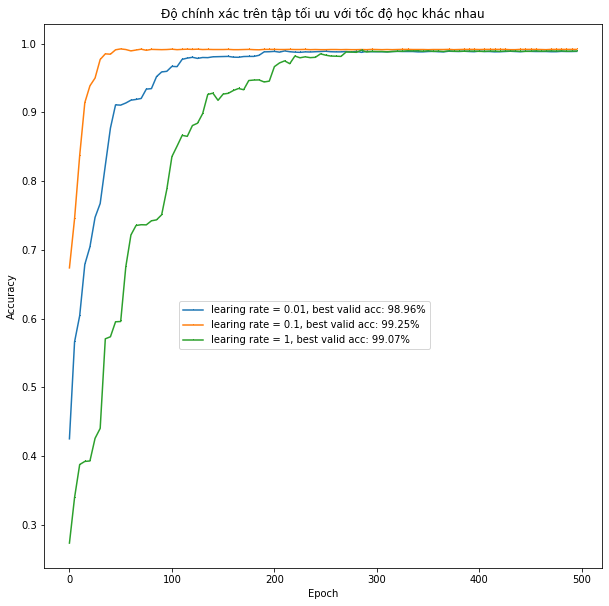

In [ ]:
sbatch=128
lrs=[0.01, 0.1, 1]
nchanels=48
nhidden=320

plt.figure(figsize=(10, 10))

for lr in lrs:
  try:
    path1 = 'result/quan_model_lr_{}_sbatch_{}_nchanels_{}_nhidden_{}'.format(lr, sbatch, nchanels, nhidden)
    with open('%s.csv'%path1, 'r') as f:
      reader = csv.reader(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
      states = [row for row in reader][1:]
      valid_acc = []
      for row in states:
        try:
          valid_acc.append(round(float(row[3]), 4))
        except:
          valid_acc.append(round(float(row[2]), 4))
        
      epochs = [i*5 for i in range(len(valid_acc))]
      plt.plot(epochs, valid_acc, marker=',', label='learing rate = {}, best valid acc: {:5.2f}%'.format(lr, max(valid_acc)*100))
  except:
    continue

plt.legend(bbox_to_anchor=(0.7, 0.5))
plt.title('Độ chính xác trên tập tối ưu với tốc độ học khác nhau')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

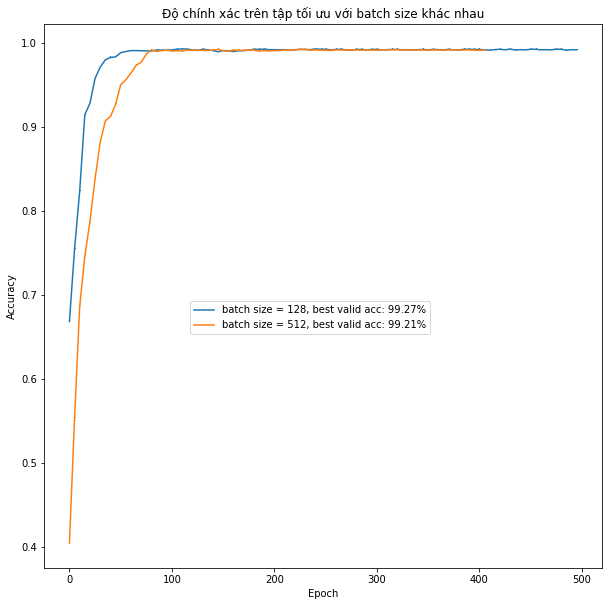

In [ ]:
sbatchs=[32, 128, 512]
lr=0.1
nchanels=48
nhidden=256

plt.figure(figsize=(10, 10))

for sbatch in sbatchs:
  try:
    path1 = 'result/quan_model_lr_{}_sbatch_{}_nchanels_{}_nhidden_{}'.format(lr, sbatch, nchanels, nhidden)
    with open('%s.csv'%path1, 'r') as f:
      reader = csv.reader(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
      states = [row for row in reader][1:]
      valid_acc = []
      for row in states:
        try:
          valid_acc.append(round(float(row[3]), 4))
        except:
          valid_acc.append(round(float(row[2]), 4))
        
      epochs = [i*5 for i in range(len(valid_acc))]
      plt.plot(epochs, valid_acc, marker=',', label='batch size = {}, best valid acc: {:5.2f}%'.format(sbatch, max(valid_acc)*100))
  except:
    continue

plt.legend(bbox_to_anchor=(0.7, 0.5))
plt.title('Độ chính xác trên tập tối ưu với batch size khác nhau')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

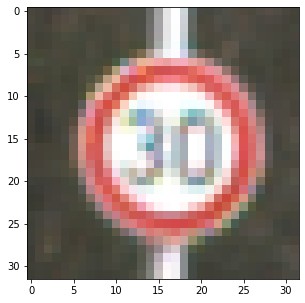

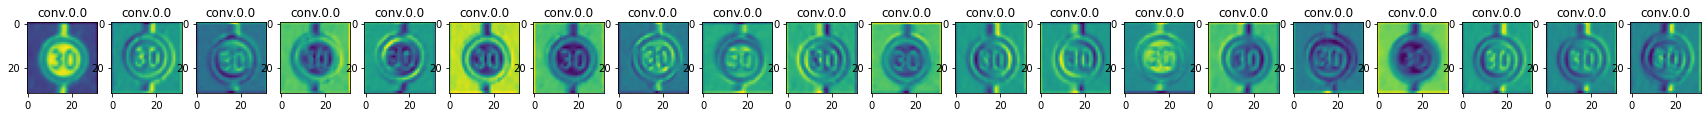

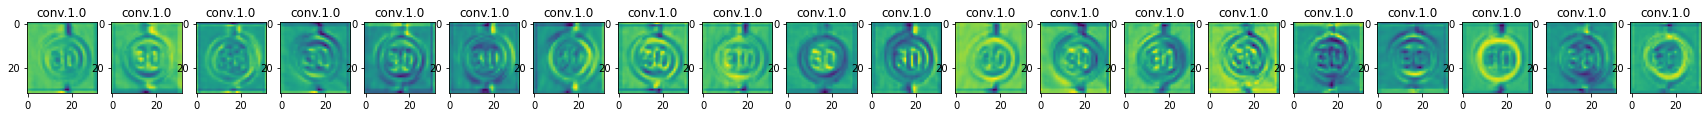

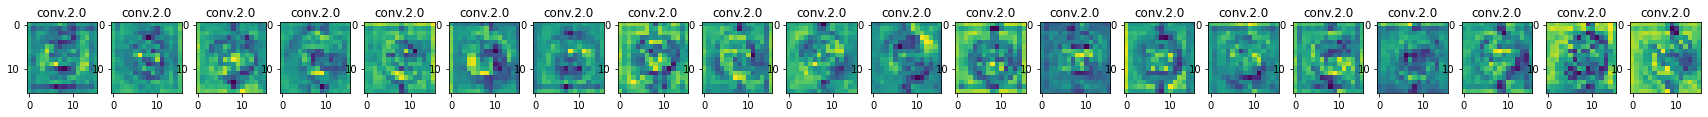

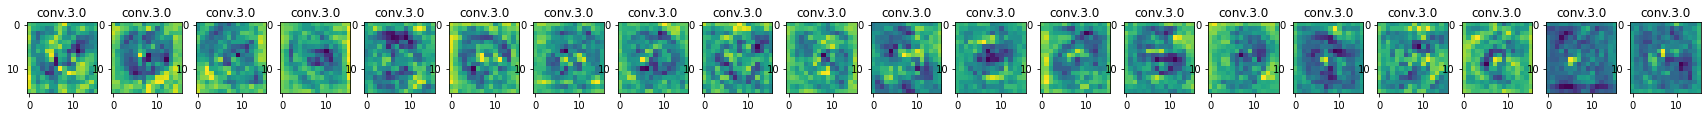

In [ ]:
fig, ax = plt.subplots(figsize = (5, 5))

inp = trainX[np.random.choice(range(len(trainX)))]

ax.imshow(inp.cpu())

in_tensor = inp.unsqueeze(0).permute(0, 3, 1, 2)
for name, module in model.named_modules():
  if isinstance(module, nn.Sequential) or isinstance(module, nn.ModuleList) or isinstance(module, Model):
    continue
  if isinstance(module, nn.Linear):
    break
  out = module(in_tensor)
  in_tensor = out
  if isinstance(module, nn.Conv2d):
    fig, ax = plt.subplots(1, 20, figsize = (30, 3))
    for i in range(20):
      p = out[0][i].cpu().detach()
      ax[i].imshow(p)
      ax[i].set_title(name) 
